In [1]:
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

import seaborn as sns

from scipy import stats
import numpy as np

from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

## 1. Загрузите датасет taxi.csv.

In [2]:
data = pd.read_csv('taxi.csv')

## 2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.

In [3]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [5]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


In [6]:
data.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response'],
      dtype='object')

### Описание столбцов

 - 'offer_gk' - уникальный ключ записи в системе. Не нужен для заказа - всегда уникальный
 - 'weekday_key' - номер дня недели (0-6), интересно - 0 это понедельник или воскресенье? Посмотрел статистику заказов, очень похоже что 0 - воскресенье. Очень похожи графики для дня 0 и 6 (см. гистограммы ниже)
 - 'hour_key' - час дня (0-23)
 - 'driver_gk' - идентификатор водителя, 439 различных значений
 - 'order_gk' - номер заказа. Их меньше, чем записей в системе. Заказ приходит к нескольким водителям с одним идентификатором номера. Чаще всего, у одного заказа либо все отказы, либо 1 прием. Но встречаются и заказы с несколькими положительными ответами от нескольких водителей. Считаю, что это некритично для наших целей - нам нужно узнать, насколько конкретный заказ нравится водителям. Для предсказания будущих заказов не нужен - у новых заказов будет другим.
 - 'driver_latitude', 'driver_longitude' - координаты водителя в момент заказа. Есть отрицательные значения, надо смотреть. Почему то очень высокая корреляция широты и долготы. Так быть не должно. После удаление значений -1 координат и отброса нуля профайлер перестал ругаться на корреляцию)) Есть одно нулевое значение координат - удаляем.
 - 'origin_order_latitude', 'origin_order_longitude' - координаты пассажира в момент заказа. Есть 13 отрицательных значений, ничего толкового я с ними не придумал, 13 значений это сотые доли процента от выборки, удаляем. Также, присутствует сильная корреляция между координатами водителя и координатами пассажира - логично, алгоритм выбирает водителей рядом с заказом.
 - 'distance_km' - Длина поездки. Есть отрицательные значения - гипотеза, что это заказы с повременной оплатой. Например, в классе Бизнес таких большинство
 - 'duration_min' - длительность поездки. Есть отрицательные значения, отрицательные значения появляются только вместе с отрицательным расстоянием
 - 'offer_class_group' - 9 классов машин. В основном - Economy & Standard. По остальным типам - сильный дисбаланс
 - 'ride_type_desc' - описание типа поездки (тип оплаты?). 4 категории. Существенный перекос в сторону private(>90%)
 - 'driver_response' - целевая переменная, которую надо предсказать
 
 Как таковых пропущенных значений нет, но много "странных" - отрицательные координаты, расстояния...
 
 Еще из забавных наблюдений - у 249 записей координаты водителя и пассажира совпадают

In [7]:
# Check for dublicates - dataframe size the same, no dublicates, can run profiler
len(data.drop_duplicates())

100000

In [8]:
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile='report.html')

In [9]:
len(data.query('distance_km < 0')['driver_gk'].unique())

439

In [10]:
data['weekday_key'].value_counts(sort=False)

0    14411
1    13089
2    12859
3    11601
4    13290
5    19284
6    15466
Name: weekday_key, dtype: int64

In [11]:
# Координаты водителя равны -1 всегда одновременно
len(data.query('(driver_longitude != -1) and (driver_latitude == -1)'))

0

In [12]:
# Координаты пассажира равны -1 всегда одновременно
len(data.query('(origin_order_longitude == -1) and (origin_order_latitude != -1)'))

0

In [13]:
data.query('driver_longitude == -1')['driver_response'].unique()

array([1], dtype=int64)

### Наблюдение - если координаты водителя (-1; -1), то ответ всегда положителен. В основном - бизнес поездки, из 140 записей 89 - из одного места. Например, это может быть предварительный заказ такси или работа по договору, техническое обслуживание. Для дальнейшего анализа будем использовать датасет без этих строк. Модель для них тривиальна)

In [14]:
data = data.drop(index=data.query('driver_longitude == -1').index)

In [15]:
# Есть нулевое значение координат водителя...
data.query('driver_longitude == 0')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
55260,271817,0,14,771,306124,0.0,0.0,55.410307,37.902451,43.726,55.45,Economy,private,0


In [16]:
# Удаляем, толковых гипотез нет
data = data.drop(index=data.query('driver_longitude == 0').index)

In [17]:
# Для точки отправления все хитрее...
data.query('origin_order_longitude == -1')#['driver_response'].unique()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
1687,760201,6,17,1479,217451,55.730637,37.491326,-1.0,-1.0,2.942,6.300,Economy,private,1
9407,729617,1,21,1835,404650,55.484133,37.850971,-1.0,-1.0,-1.000,-1.000,Standard,private,0
43328,1033378,3,10,5586,386108,55.762383,37.772572,-1.0,-1.0,14.127,21.433,Economy,private,1
43688,299807,3,18,14,69484,55.640164,37.534014,-1.0,-1.0,9.998,22.133,Standard,private,1
51365,833482,0,20,75,782429,55.619920,37.395172,-1.0,-1.0,28.607,32.967,Economy,private,0
56004,1009826,3,19,4185,247078,55.758792,37.749308,-1.0,-1.0,11.281,21.167,Economy,private,1
58769,212838,2,7,6304,542162,55.638462,37.335678,-1.0,-1.0,48.557,47.300,Economy,private,0
60245,753313,1,16,1168,583148,55.984804,37.159184,-1.0,-1.0,-1.000,-1.000,Economy,private,1
64117,936069,5,15,737,139197,55.753351,37.667157,-1.0,-1.0,2.252,7.400,Standard,private,1
64694,1095202,3,20,5669,659570,55.741113,37.618121,-1.0,-1.0,7.199,20.200,Premium,private,1


In [18]:
order_ids = data.query('origin_order_longitude == -1')['order_gk'].unique()

for cur in order_ids:
    tmp_df = data.query('order_gk == @cur')
# Commented to keep it brief
#    print(tmp_df) 

Пробовали посмотреть, нет ли информации в других строках по этому заказу. Ничего интересного - те же строки.

In [19]:
# Пока тоже дропнем - непонятно, что делать с отсутствующими координатами точки заказа...
data = data.drop(index=data.query('origin_order_longitude == -1').index)

In [20]:
# Посмотрим на значения с одинаковыми координатами
data.query('driver_latitude == origin_order_latitude & driver_longitude == origin_order_longitude').head()#['driver_gk'].unique()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
13476,1128129,2,2,2291,528947,55.605226,37.286083,55.605226,37.286083,33.061,33.317,Standard,private,1
13478,317266,2,2,2291,663618,55.605226,37.286083,55.605226,37.286083,53.002,51.950,Standard,private,1
13510,1045389,6,22,2291,310002,55.605226,37.286083,55.605226,37.286083,41.300,53.067,Standard,private,1
13511,713496,6,22,2291,294521,55.605226,37.286083,55.605226,37.286083,-1.000,-1.000,Standard,private,1
13537,916815,6,22,2291,311365,55.605226,37.286083,55.605226,37.286083,51.210,60.350,Standard,private,1


In [21]:
# Координаты совпадают у шести водителей
data.query('driver_latitude == origin_order_latitude & driver_longitude == origin_order_longitude')['driver_gk'].unique()

array([2291, 3860, 5718, 6762,  771, 5013], dtype=int64)

In [22]:
data.query('driver_latitude == origin_order_latitude & driver_longitude == origin_order_longitude & driver_gk == 3860')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
15286,389220,5,12,3860,422704,55.976109,37.319016,55.976109,37.319016,-1.0,-1.0,Standard,private,0


2291 - ожидал во Внуково и всегда брал заказ (наверное, нормальное поведение), 3860 - просто совпали координаты, остальные пасутся в Шереметьево и относительно редко берут заказы. Совпадение координат будет нам мешать при вычислении косинусного расстояния, добавим к долготе 0.0000005, из широты вычтем 0.0000005 - влияние на результат будет минимальным (отклонение - несколько сантиметров)

In [23]:
for idx in data.query('driver_latitude == origin_order_latitude & driver_longitude == origin_order_longitude').index:
    data.at[idx, 'driver_latitude'] -= 0.0000005
    data.at[idx, 'driver_longitude'] += 0.0000005

In [24]:
data.query('driver_latitude == origin_order_latitude & driver_longitude == origin_order_longitude')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response


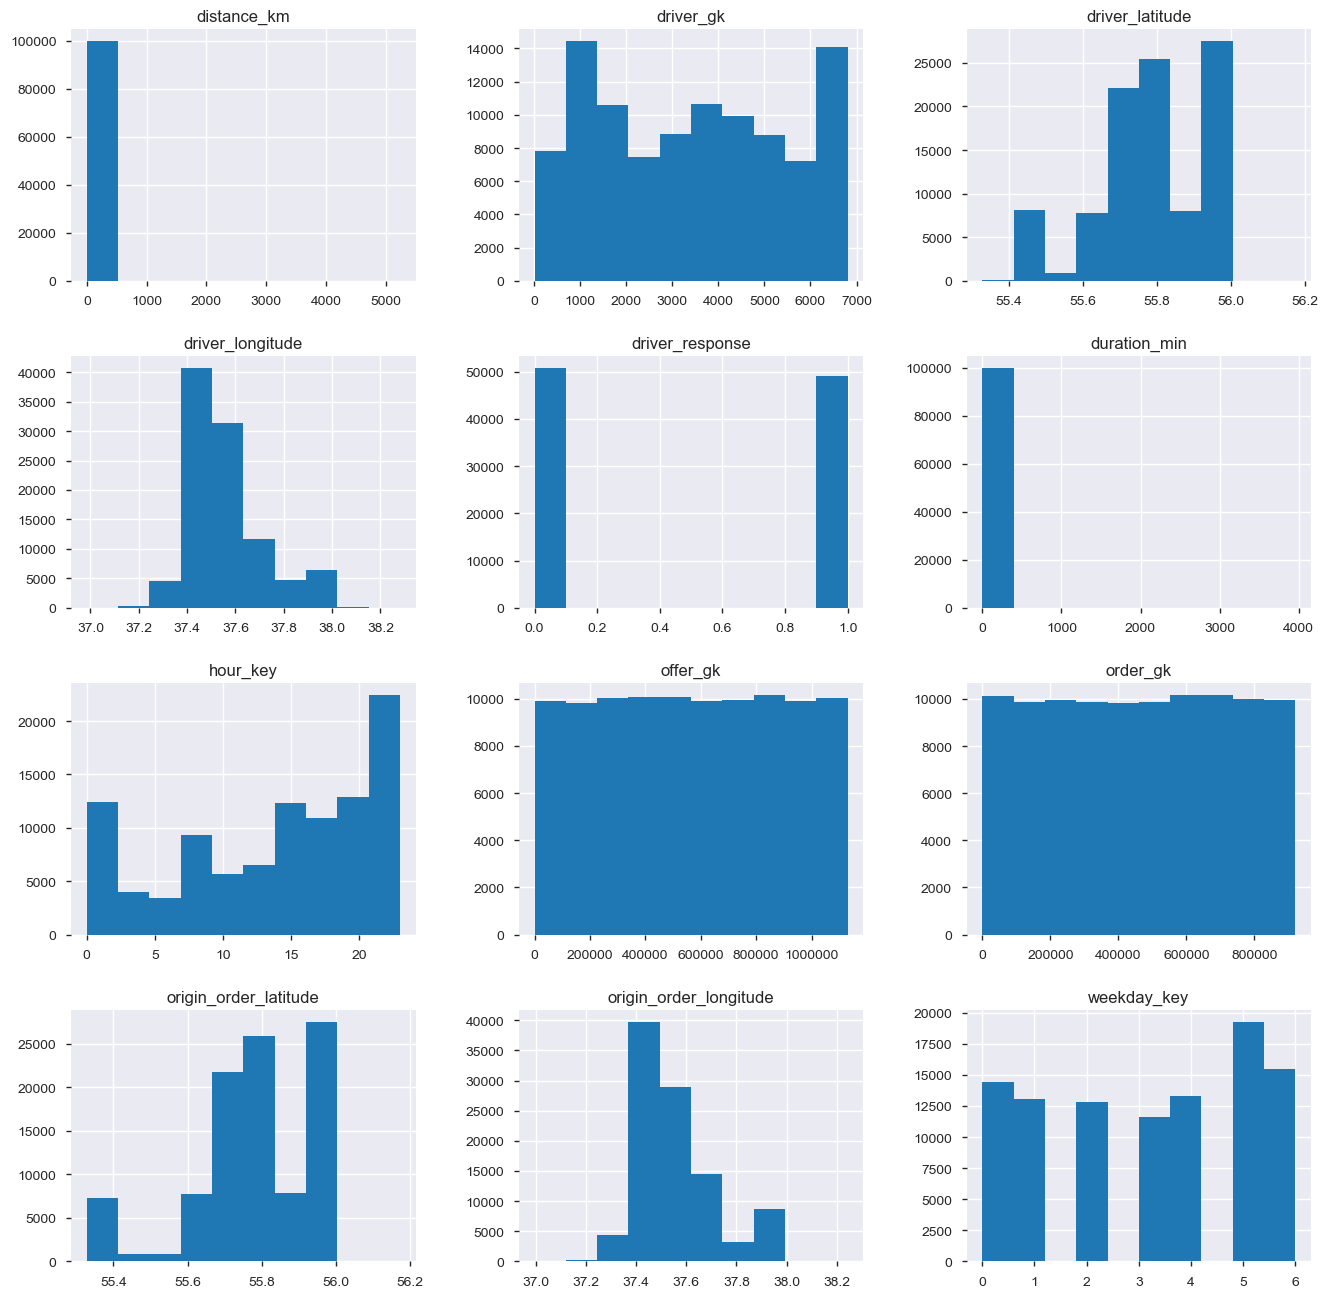

In [25]:
rcParams['figure.figsize'] = 16,16
data.hist()
plt.show()

In [26]:
# Аналогично - расстояние и время поездки становятся -1 одновременно
data.query('(distance_km != -1) and (duration_min == -1)')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response


In [27]:
len(data.query('distance_km == -1'))

26083

Отрицательные расстояния - норма для этого датасета... Надо придумать объяснение...

In [28]:
# ids = data.query('distance_km == -1').order_gk.unique()

# for cur in ids:
#     tmp_df = data.query('order_gk == @cur')
#     non_null_items = len(tmp_df.query('distance_km != -1'))
#     if non_null_items:
#         print(cur)
# Закомментировано из соображений ускорения - проверка на одновременное наличие отрицательных и положительных 
# значений ответа в одном заказе - таких нет. 

In [29]:
data.query('ride_type_desc == "business"')['distance_km'].value_counts().head()

-1.000     8250
 20.325       4
 47.989       3
 14.055       3
 17.301       2
Name: distance_km, dtype: int64

Единственное объяснение отрицательных значений, которое пришло мне в голову, это заказ такси с повременной оплатой. Например, большая часть бизнес заказов (8250 из 8553) именно такие. У других типов такое и сейчас есть, но редко, я спрашивал таксистов))

In [30]:
order_count = data['order_gk'].value_counts().to_frame().reset_index()
order_count.head()

,index,order_gk
0,853342,14
1,714527,13
2,761031,13
3,341619,12
4,896087,12


In [31]:
order_count = order_count.rename(columns={'order_gk':'order_count'})


In [32]:
order_count.head()

,index,order_count
0,853342,14
1,714527,13
2,761031,13
3,341619,12
4,896087,12


In [33]:
data.query('order_gk == 896087')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
24974,961514,2,0,4100,896087,55.961150,37.413188,55.962322,37.407117,-1.0,-1.0,Standard,private,0
25746,445267,2,0,1793,896087,55.962122,37.409464,55.962322,37.407117,-1.0,-1.0,Standard,private,0
27048,537041,2,0,2381,896087,55.961529,37.413888,55.962322,37.407117,-1.0,-1.0,Standard,private,0
27668,1114784,2,0,1060,896087,55.961859,37.407126,55.962322,37.407117,-1.0,-1.0,Standard,private,0
30326,453399,2,0,5917,896087,55.962323,37.407117,55.962322,37.407117,-1.0,-1.0,Standard,private,0
31271,808686,2,0,6762,896087,55.964892,37.413543,55.962322,37.407117,-1.0,-1.0,Standard,private,0
41505,1026900,2,0,1537,896087,55.962323,37.407114,55.962322,37.407117,-1.0,-1.0,Standard,private,0
60426,491856,2,0,975,896087,55.960537,37.413353,55.962322,37.407117,-1.0,-1.0,Standard,private,0
69489,264473,2,0,4490,896087,55.961917,37.409716,55.962322,37.407117,-1.0,-1.0,Standard,private,0
72847,87328,2,0,462,896087,55.962068,37.417515,55.962322,37.407117,-1.0,-1.0,Standard,private,0


Пробежался по самым частым занчениям заказов - ночью из Шереметьево уехать действительно сложно.

In [34]:
# Проверяем, что для каждого заказа есть не более одного положительного ответа
orders = order_count.query('order_count > 1')['index'].to_list()
# print(orders)
strange_orders = set()
for cur in orders:
    if sum(data.query('order_gk == @cur')['driver_response']) >1:
        strange_orders.add(cur)

print(len(strange_orders))
print(strange_orders)

# У 164 заказов более одного положительного ответа... пошли искать

164
{850944, 105474, 45571, 22536, 889875, 190998, 63002, 166427, 677404, 207898, 455708, 522788, 379429, 72232, 791081, 15403, 743982, 185393, 124977, 867380, 365620, 243254, 621108, 471610, 782397, 313406, 882239, 73796, 850511, 903255, 179800, 508505, 93279, 187489, 623718, 398444, 222320, 834673, 103539, 245372, 708732, 720513, 217222, 591496, 235148, 428173, 430746, 855198, 455851, 540846, 67248, 358578, 591028, 877749, 820413, 903870, 452288, 877761, 635586, 48833, 599746, 41157, 181958, 521927, 301248, 175822, 600276, 640215, 376023, 183002, 504034, 836328, 732904, 101610, 477929, 362738, 2810, 29435, 558333, 159487, 728833, 584452, 54540, 64268, 92942, 513804, 532751, 265998, 822035, 461590, 339740, 120097, 820518, 641839, 236336, 388404, 314676, 848696, 63801, 105786, 871737, 130375, 517962, 603471, 507727, 521040, 394071, 181079, 182105, 137561, 52571, 737627, 381789, 601597, 459110, 371559, 173422, 549236, 655224, 330110, 720770, 533892, 610693, 656777, 611721, 745356, 90356

In [35]:
data.query('order_gk == 376023')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
18180,281290,5,23,4014,376023,55.677727,37.581903,55.668435,37.560884,36.545,60.917,Economy,private,1
79450,396129,5,23,42,376023,55.665152,37.580082,55.668435,37.560884,36.545,60.917,Economy,private,1


Посмотрел несколько значение - ничего особенно криминального. Просто несколько водиетелей успевают принять заказ

# Playing with distance

In [36]:
td = data.drop(index=data.query('distance_km == -1').index)

In [37]:
td.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,7.376300e+04,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000,73763.000000
mean,5.657853e+05,3.150319,13.800767,3461.440031,461946.017678,55.780802,37.546502,55.780146,37.546159,25.275859,31.701796,0.471632
std,3.262780e+05,2.078224,7.316146,2038.989444,266094.868170,0.157293,0.160271,0.159559,0.163071,45.954683,35.725776,0.499198
min,4.000000e+00,0.000000,0.000000,14.000000,27.000000,55.367720,36.984771,55.342523,36.994072,0.000000,0.000000,0.000000
25%,2.849005e+05,1.000000,8.000000,1421.000000,230732.500000,55.705842,37.413468,55.705636,37.407117,7.901000,16.567000,0.000000
50%,5.648310e+05,3.000000,16.000000,3507.000000,463129.000000,55.774829,37.528477,55.775037,37.527348,18.605000,28.183000,0.000000
75%,8.495825e+05,5.000000,20.000000,5246.000000,692512.000000,55.961102,37.625658,55.962322,37.625474,38.735000,44.333000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.018542,38.232760,56.025061,38.204119,5234.283000,3958.283000,1.000000


In [38]:
len(td.query('distance_km == 0'))

152

152 нулевых расстояния...

In [39]:
td.query('distance_km == 0').head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
859,346101,4,12,4215,70206,55.758458,37.710545,55.747802,37.715600,0.0,0.0,Economy,private,1
1179,166480,5,8,1706,234100,55.787066,37.563235,55.792505,37.563787,0.0,0.0,Economy,private,1
2435,839922,3,12,6792,845047,55.415367,37.898310,55.410307,37.902451,0.0,0.0,Standard,private,1
2918,904433,5,18,1514,228992,55.681763,37.480773,55.671333,37.464131,0.0,0.0,Standard,private,0
3357,149416,4,6,4269,401598,55.961844,37.409798,55.961995,37.406355,0.0,0.0,Economy,private,0


In [40]:
td.query('order_gk == 70206')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
859,346101,4,12,4215,70206,55.758458,37.710545,55.747802,37.7156,0.0,0.0,Economy,private,1


In [41]:
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(td)
profile.to_file(outputfile='report_2.html')

In [42]:
td.query('distance_km > 1000')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
3794,301985,1,12,6486,118610,55.881154,37.652396,55.886504,37.662542,1274.213,920.383,Standard,private,1
6110,198416,4,17,2333,914494,55.733757,37.405701,55.734689,37.402236,1479.538,1014.283,Standard,private,0
10089,873470,1,16,6580,660752,55.831685,37.453510,55.827200,37.444590,1475.580,1149.667,Standard,private,0
13973,174541,1,20,5714,706021,55.808453,37.527302,55.809480,37.529113,1725.533,1254.050,Economy,private,1
14331,391059,6,15,2410,633727,55.602245,37.589453,55.592491,37.609445,1474.938,1159.000,XL,private,1
16195,300724,3,8,2337,552511,55.758244,37.595790,55.747323,37.629043,1228.398,908.683,VIP,private,1
19211,72178,5,19,5423,129344,55.759206,37.619783,55.757147,37.621828,1058.824,871.000,Standard,private,1
20181,663228,2,10,6620,595082,55.904525,37.716110,55.897311,37.732915,1437.253,951.733,Standard,private,1
37485,552747,1,18,6666,219128,55.746030,37.537630,55.757527,37.549621,5215.793,3947.383,VIP,private,1
37639,538141,6,18,994,463224,55.767603,37.600957,55.769065,37.604302,4177.900,3112.217,Standard,private,1


Присутсвуют нулевые значения расстояний, очень маленькие значения (<500 метров) и очень большие значения (>1000 км). Тем не менее, поведение водителей по этим заказам нормальное - есть приемы, есть отказы. Нам не известно, что дальше происходит с заказом (например, возможна отмена пользователем при ошибочном вводе места назначения), но водители реагируют на них, как на "нормальные" поездки. Также, из разговора с таксистами, я узнал, что часто они не видят никакой информации о длительности или пункте назначения. Пока оставляем как есть.

In [43]:
# Переделываем отчет - графики координат станут красивее :)
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile='report.html')

## 3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.

Сделано. см. выше

## 4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.

Сделано. см. выше

## 5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).

Формально, есть 2 категориальных признака - ride_type_desc описание типа (способа оплаты) поездки, 4 типа и offer_class_group - класс машины (9 типов). Также, к категориальным признакам относятся день недели и час заказа. Ну и главный категориальный признак - номер водителя и номер заказа. Поехали разбираться

In [44]:
data.ride_type_desc.value_counts()

private      91183
business      8403
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [45]:
ride_type = data.ride_type_desc.unique()

for cur in ride_type:
    print(cur)
    print(data.query('ride_type_desc == @cur')['driver_response'].value_counts())

private
0    47154
1    44029
Name: driver_response, dtype: int64
business
1    4937
0    3466
Name: driver_response, dtype: int64
affiliate
0    113
1    111
Name: driver_response, dtype: int64
SMB
1    23
0    13
Name: driver_response, dtype: int64


In [46]:
private_resp = data.query('ride_type_desc == "private"')['driver_response']
business_resp = data.query('ride_type_desc == "business"')['driver_response']
affiliate_resp = data.query('ride_type_desc == "affiliate"')['driver_response']
smb_resp = data.query('ride_type_desc == "SMB"')['driver_response']

stats.ttest_ind(private_resp, business_resp)#, affilate_resp, smb_resp)

Ttest_indResult(statistic=-18.394796058674473, pvalue=1.9295772869503672e-75)

In [47]:
stats.ttest_ind(private_resp, smb_resp)

Ttest_indResult(statistic=-1.873035502286855, pvalue=0.06106667826498217)

In [48]:
stats.ttest_ind(business_resp, affiliate_resp)#, smb_resp)

Ttest_indResult(statistic=2.7588266477700953, pvalue=0.005813158616146403)

In [49]:
stats.ttest_ind(private_resp, affiliate_resp)#, smb_resp)

Ttest_indResult(statistic=-0.3790547867679568, pvalue=0.704648060660023)

In [50]:
stats.ttest_ind(business_resp, smb_resp)

Ttest_indResult(statistic=-0.6246471281807034, pvalue=0.5322195724335348)

Статистически значимыми являются отличия в ответах в при типе заказа business. Остальные - достаточно похожи. Заменим все affilate & SMB на private

In [51]:
for idx in data.query('ride_type_desc == "SMB"').index:
    data.at[idx, 'ride_type_desc'] = 'private'
    
for idx in data.query('ride_type_desc == "affiliate"').index:
    data.at[idx, 'ride_type_desc'] = 'private'

In [52]:
data.ride_type_desc.unique()

array(['private', 'business'], dtype=object)

In [53]:
data['is_business'] = data.ride_type_desc.apply(lambda x: int(x=='business'))

In [56]:
data.offer_class_group.value_counts()

Economy     48317
Standard    47159
Premium      1770
Delivery     1286
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [57]:
offer_class = data.offer_class_group.unique()

for cur in offer_class:
    print(cur)
    print(data.query('offer_class_group == @cur')['driver_response'].value_counts())

Economy
0    27110
1    21207
Name: driver_response, dtype: int64
Standard
1    24628
0    22531
Name: driver_response, dtype: int64
XL
1    330
0    134
Name: driver_response, dtype: int64
Kids
1    494
0     94
Name: driver_response, dtype: int64
Delivery
1    870
0    416
Name: driver_response, dtype: int64
Test
1    6
0    2
Name: driver_response, dtype: int64
Premium
1    1365
0     405
Name: driver_response, dtype: int64
VIP
1    174
0     51
Name: driver_response, dtype: int64
VIP+
1    26
0     3
Name: driver_response, dtype: int64


In [58]:
economy_resp = data.query('offer_class_group == "Economy"')['driver_response']
standard_resp = data.query('offer_class_group == "Standard"')['driver_response']

stats.ttest_ind(economy_resp, standard_resp)

Ttest_indResult(statistic=-25.8533779166695, pvalue=7.167797670159174e-147)

In [59]:
xl_resp = data.query('offer_class_group == "XL"')['driver_response']
premium_resp = data.query('offer_class_group == "Premium"')['driver_response']
vip_resp = data.query('offer_class_group == "VIP"')['driver_response']

stats.ttest_ind(xl_resp, premium_resp)

Ttest_indResult(statistic=-2.6910392736632724, pvalue=0.007176109537484147)

In [60]:
stats.ttest_ind(premium_resp, vip_resp)

Ttest_indResult(statistic=-0.07220058369390166, pvalue=0.9424495252307433)

Ответы в категориях Premium & VIP одинаковые - объединим, в остальных категориях - статистически различаются. Уберем класс тест - все 8 заказов были в категории СМБ. Судя по названию, никакой существенной информции нет.

In [61]:
data = data.drop(index=data.query('offer_class_group == "Test"').index)

for idx in data.query('offer_class_group == "VIP"').index:
    data.at[idx, 'offer_class_group'] = 'Premium'

In [62]:
data.offer_class_group.unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Premium', 'VIP+'],
      dtype=object)

In [63]:
for cur in ride_type:
    print(cur)
    print(data.query('ride_type_desc == @cur')['offer_class_group'].unique())

private
['Economy' 'Standard' 'XL' 'Kids' 'Delivery' 'Premium' 'VIP+']
business
['Standard' 'Economy' 'Delivery' 'Premium']
affiliate
[]
SMB
[]


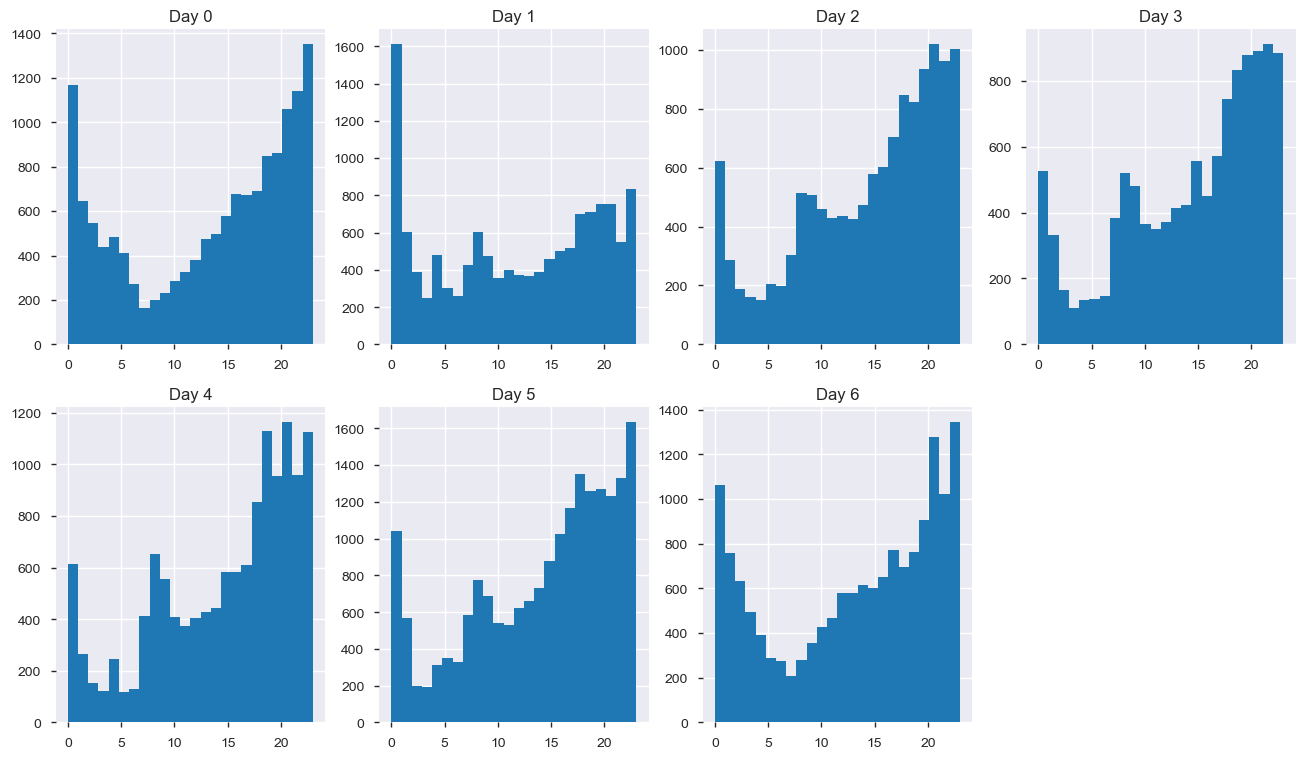

In [66]:
# Нарисуем гистограммы кол-ва запросов по дням. Очень похожи гистограммы для дня 0 и 6 - думаю, 
# это выходные, 0 - воскресенье, 6 - суббота
rcParams['figure.figsize'] = 16,9

weekdays = data.weekday_key.unique()
for cur in weekdays:
    plt.subplot(2, 4, cur+1)
    plt.hist(data.query('weekday_key == @cur')['hour_key'], bins=24)
    plt.title(f'Day {cur}')

Сделаем категориальный признак - будний день (0) или выходной (1). Также, разложим часы по "корзинам" - ночь (1-6 часов)(0), утро (7-9 часов)(1), день1 (10-14)(2), день2 (15-17)(3), вечер(18-23 +0)(4).

In [67]:
def day_code(day_key):
    if (day_key == 0) or (day_key == 6):
        return 1
    else:
        return 0
    
def hour_code(hour_key):
    if (hour_key >= 1) and (hour_key <= 6):
        return 0
    elif (hour_key >= 7) and (hour_key <= 9):
        return 1
    elif (hour_key >= 10) and (hour_key <= 14):
        return 2
    elif (hour_key >= 15) and (hour_key <= 17):
        return 3
    else:
        return 4

In [68]:
data['is_weekend'] = data['weekday_key'].apply(day_code)

In [69]:
data['hour_bin'] = data['hour_key'].apply(hour_code)

In [70]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_business,is_weekend,hour_bin
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,0,0,4
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,0,0,2
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0,1,2
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,0,0,0
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,0,0,3


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99838 entries, 0 to 99999
Data columns (total 17 columns):
offer_gk                  99838 non-null int64
weekday_key               99838 non-null int64
hour_key                  99838 non-null int64
driver_gk                 99838 non-null int64
order_gk                  99838 non-null int64
driver_latitude           99838 non-null float64
driver_longitude          99838 non-null float64
origin_order_latitude     99838 non-null float64
origin_order_longitude    99838 non-null float64
distance_km               99838 non-null float64
duration_min              99838 non-null float64
offer_class_group         99838 non-null object
ride_type_desc            99838 non-null object
driver_response           99838 non-null int64
is_business               99838 non-null int64
is_weekend                99838 non-null int64
hour_bin                  99838 non-null int64
dtypes: float64(6), int64(9), object(2)
memory usage: 16.2+ MB


## 6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.

Для начала займемся координатами водителя и пассажира. Самое простое, что можно сделать - посчитать Евклидово расстояние. Ещё есть так называемая манхэттэнская метрика (https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2) - ее я тоже посчитаю. Также, пришла в голову мысль о возможной зависимости ответа от направления (в центр, из центра), для определения направления посчитаем угол между вектором водитель-пассажир и вектором, соединяющим нулевой километр и местоположение водителя (косинусное растояние).

Самой адекватной метрикой расстояния, как мне кажется, является длина и продолжительность маршрута до пассажира с учетом текущей дорожной ситуации. Но посчитать достаточно сложно - Яндекс и Гугл предлагают такие услуги за деньги, буду думать...

In [73]:
p1_lat = np.array(data.driver_latitude).reshape(-1, 1)
p1_long = np.array(data.driver_longitude).reshape(-1, 1)
p2_lat = np.array(data.origin_order_latitude).reshape(-1, 1)
p2_long = np.array(data.origin_order_longitude).reshape(-1, 1)

In [74]:
driver_dir = np.hstack((p2_lat-p1_lat, p2_long-p1_long))

In [75]:
zero_vec = np.hstack((p1_lat-55.75578, p1_long-37.61786))

In [76]:
# Cosine distance
cos_dist = np.zeros(len(driver_dir))
for idx in range(len(driver_dir)):
    cos_dist[idx] = cosine(driver_dir[idx], zero_vec[idx])
#     print(cosine(driver_dir[idx], zero_vec[idx]))

# Косинусное расстояние выдает 1-cos(x) - так и оставим, не все алгоритмы работают с отрицательными числами


In [77]:
# Euclidean distance
euc_dist = np.zeros(len(driver_dir))
for idx in range(len(driver_dir)):
    euc_dist[idx] = np.linalg.norm(driver_dir[idx])

In [78]:
# Manhattan distance
manhattan_dist = np.zeros(len(driver_dir))

driver_vec = np.hstack((p1_lat, p1_long))
pass_vec = np.hstack((p2_lat, p2_long))

for idx in range(len(driver_dir)):
    manhattan_dist[idx] = cityblock(driver_vec[idx], pass_vec[idx])

In [79]:
data['cos_dist'] = cos_dist
data['euc_dist'] = euc_dist
data['manhattan_dist'] = manhattan_dist

In [80]:
# Переделываем отчет - графики координат станут красивее :)
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile='report_3.html')

In [81]:
# Table with non-zero distance
td = data.drop(index=data.query('distance_km == -1').index)

In [82]:
# Adding log of distance
td['log_distance'] = np.log(td['distance_km']+1)
td['log_euc'] = np.log(td['euc_dist']+1)


In [83]:
# td = td.drop(index=td.query('duration_min == 0').index)


In [84]:
# Переделываем отчет - графики координат станут красивее :)
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(td)
profile.to_file(outputfile='report_4.html')

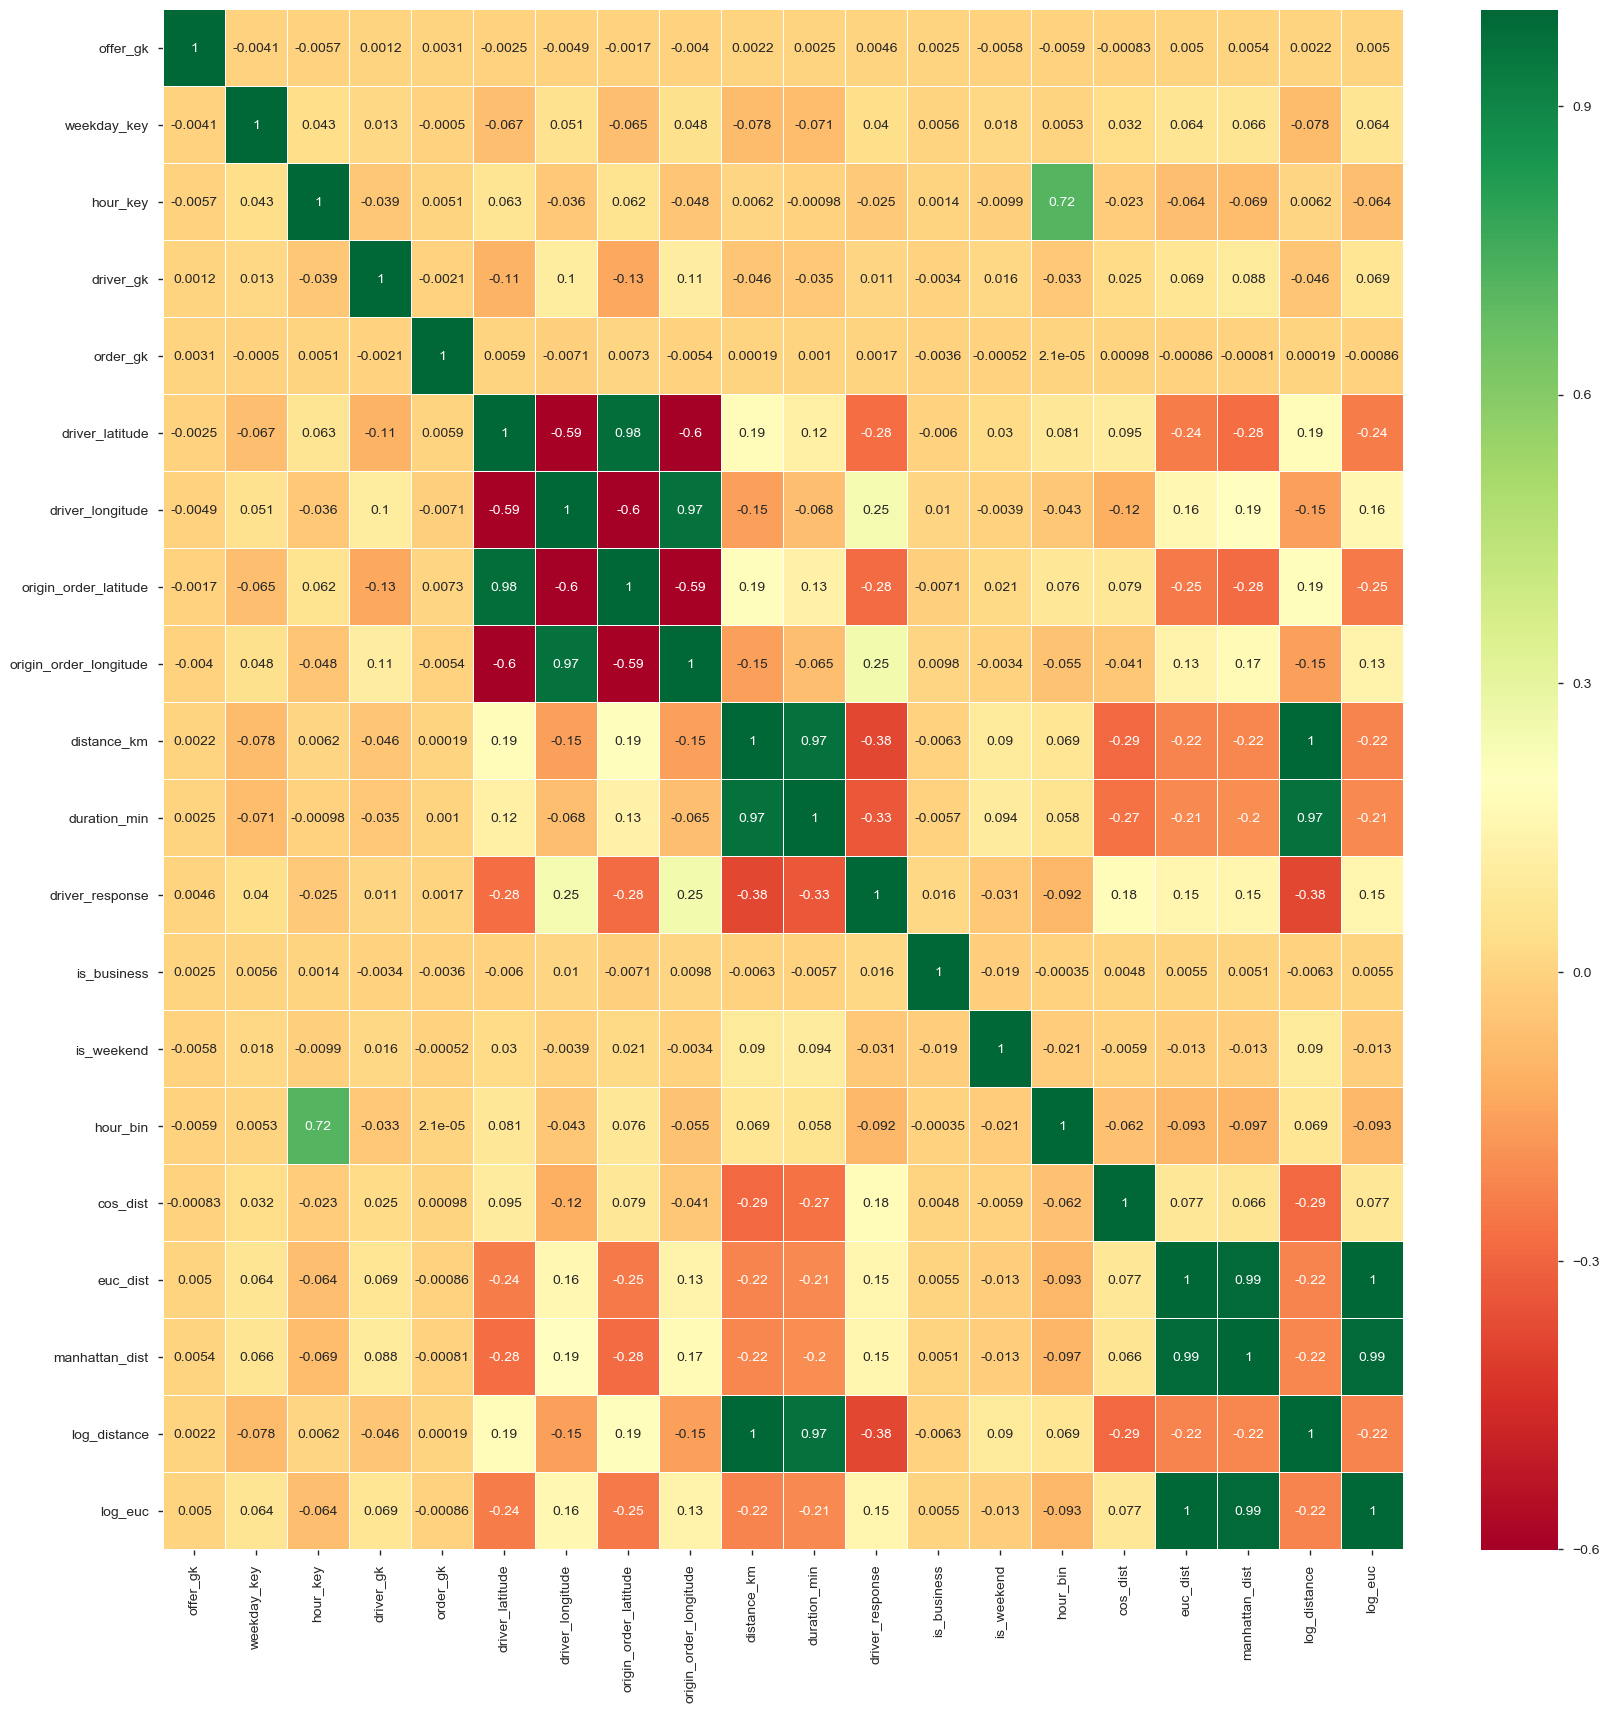

In [85]:
rcParams['figure.figsize'] = 20,20

ax = sns.heatmap(td.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [86]:
# Table with unknown distance to destination
zero_df = data.drop(index=data.query('distance_km != -1').index)

In [87]:
zero_df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_business,is_weekend,hour_bin,cos_dist,euc_dist,manhattan_dist
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.0,-1.0,Economy,private,0,0,0,4,1.999916,0.020890,0.024723
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.0,-1.0,Economy,private,1,0,0,0,1.953559,0.009697,0.011835
6,103326,2,11,6080,615584,55.753508,37.663742,55.757251,37.659064,-1.0,-1.0,Standard,business,1,1,0,2,1.810763,0.005991,0.008421
19,533917,5,8,6080,596531,55.913718,37.401395,55.921554,37.403505,-1.0,-1.0,Standard,business,0,1,0,1,0.640902,0.008115,0.009946
21,123897,4,12,6080,185909,55.766763,37.607275,55.772388,37.606330,-1.0,-1.0,Standard,business,0,1,0,2,0.174948,0.005704,0.006570


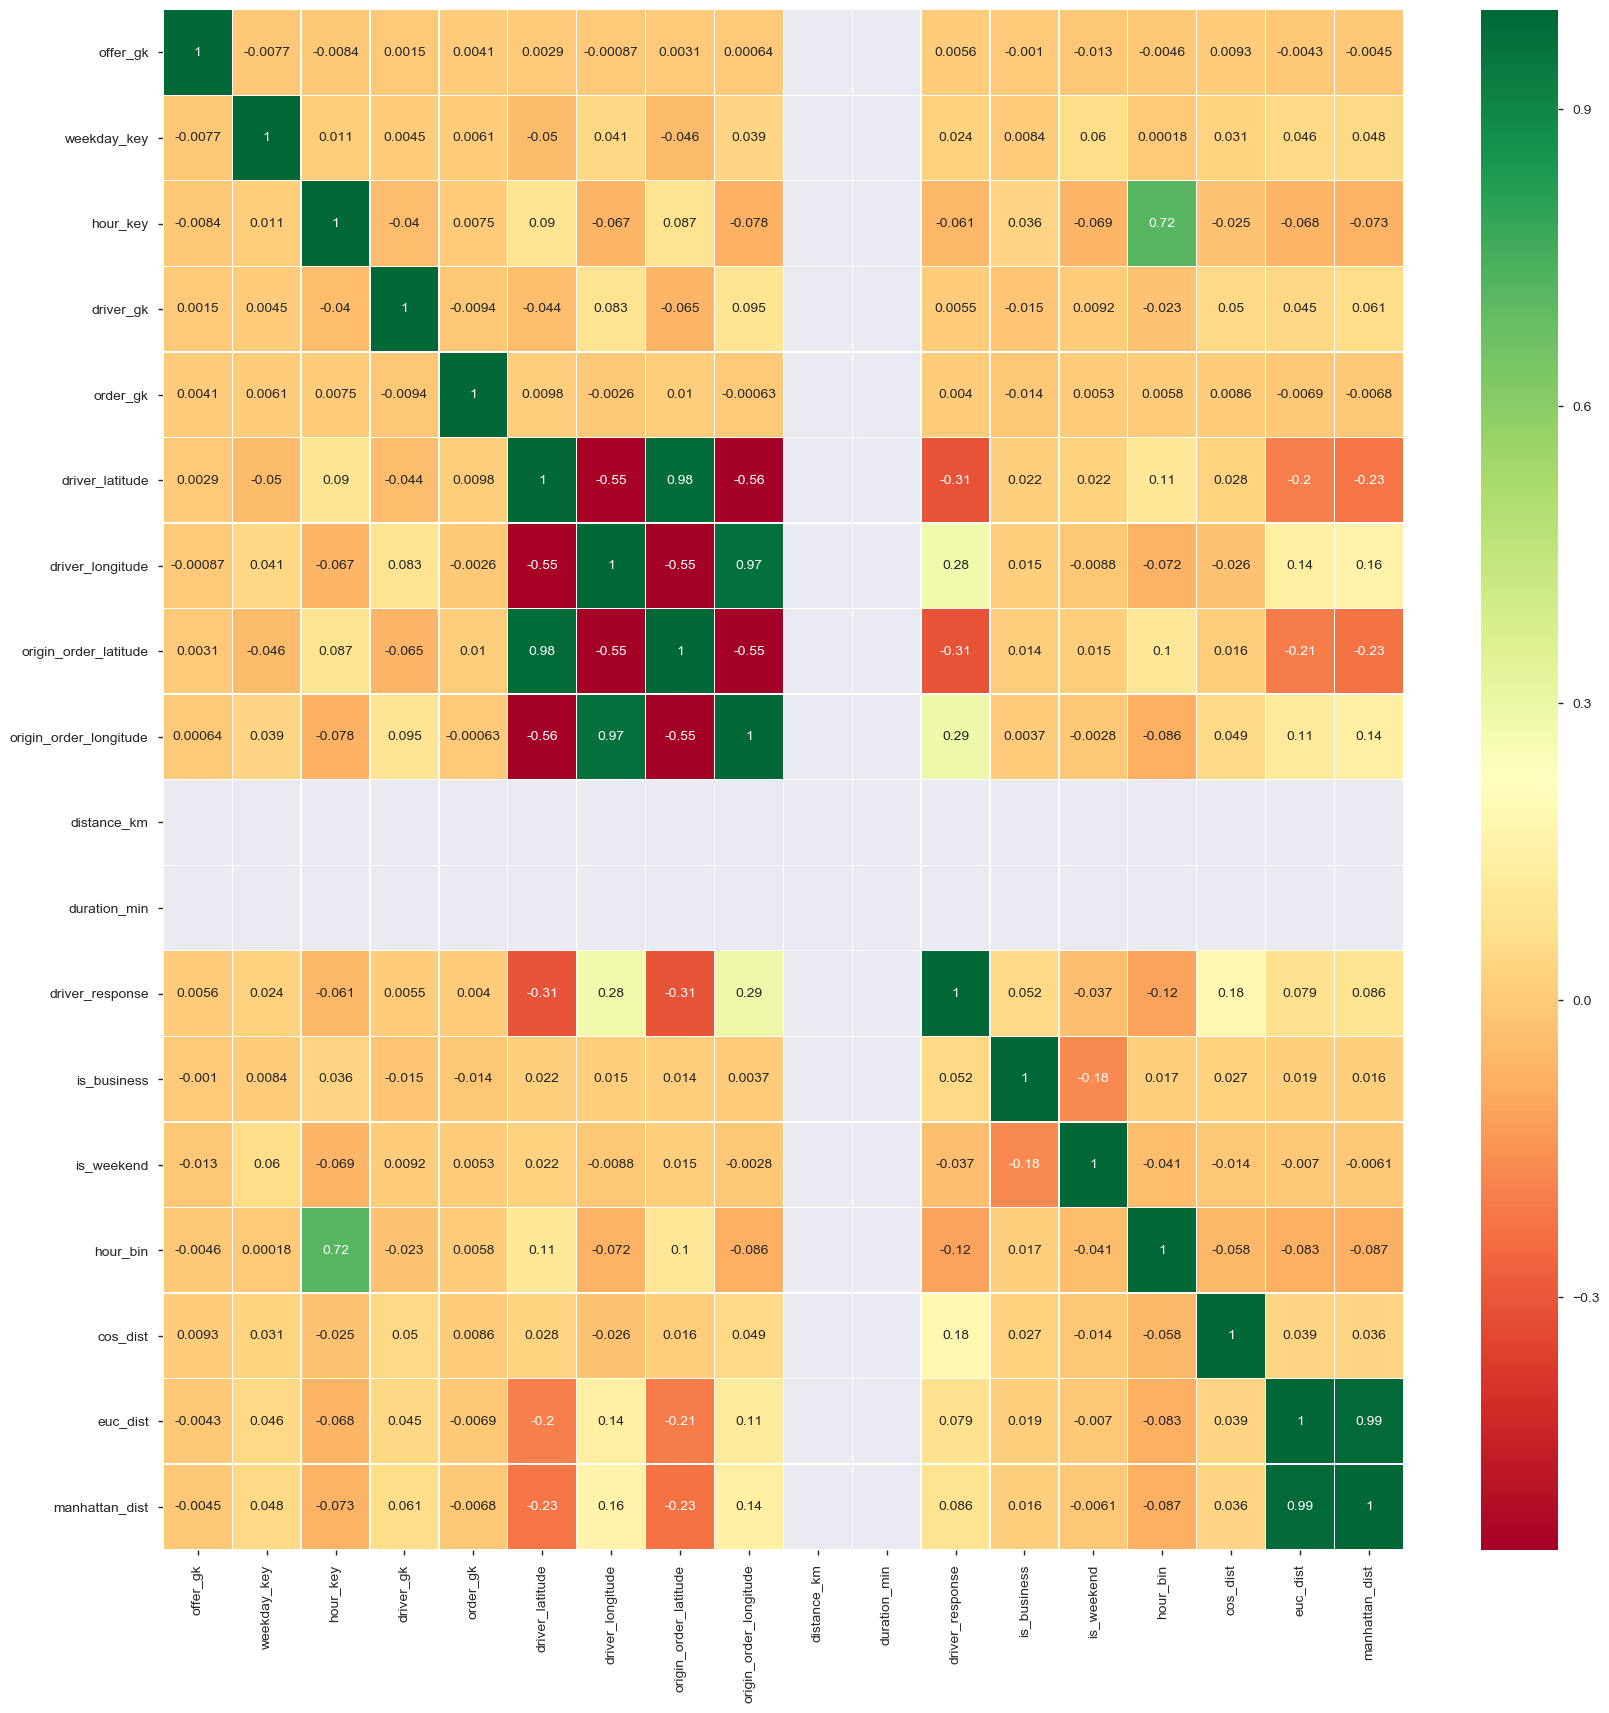

In [88]:
rcParams['figure.figsize'] = 20,20

ax = sns.heatmap(zero_df.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [89]:
#Drop coordinates columns & info about exact order - this will cause overfitting
td = td.drop(columns=['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude', 
                      'offer_gk', 'order_gk'])
td.head()

,weekday_key,hour_key,driver_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_business,is_weekend,hour_bin,cos_dist,euc_dist,manhattan_dist,log_distance,log_euc
1,5,14,6080,18.802,25.217,Standard,private,1,0,0,2,0.014249,0.050597,0.062612,2.985783,0.049358
2,6,14,6080,6.747,9.800,Economy,private,0,0,1,2,1.941298,0.006442,0.007235,2.047306,0.006422
4,4,16,6080,12.383,19.250,Economy,private,1,0,0,3,1.112683,0.010694,0.014786,2.593985,0.010637
5,6,15,6080,6.747,9.800,Economy,private,0,0,1,3,0.287309,0.008095,0.011095,2.047306,0.008063
7,5,20,6080,1.517,3.933,Economy,private,0,0,0,4,1.976048,0.055239,0.055423,0.923068,0.053768


In [90]:
zero_df = zero_df.drop(columns=['driver_latitude', 'driver_longitude', 'origin_order_latitude', 
                                'origin_order_longitude','order_gk', 'offer_gk', 'distance_km', 'duration_min'])
zero_df.head()

,weekday_key,hour_key,driver_gk,offer_class_group,ride_type_desc,driver_response,is_business,is_weekend,hour_bin,cos_dist,euc_dist,manhattan_dist
0,5,20,6080,Economy,private,0,0,0,4,1.999916,0.020890,0.024723
3,2,6,6080,Economy,private,1,0,0,0,1.953559,0.009697,0.011835
6,2,11,6080,Standard,business,1,1,0,2,1.810763,0.005991,0.008421
19,5,8,6080,Standard,business,0,1,0,1,0.640902,0.008115,0.009946
21,4,12,6080,Standard,business,0,1,0,2,0.174948,0.005704,0.006570


In [91]:
td = td.drop(columns='ride_type_desc')
zero_df = zero_df.drop(columns='ride_type_desc')

In [92]:
td.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73763 entries, 1 to 99999
Data columns (total 15 columns):
weekday_key          73763 non-null int64
hour_key             73763 non-null int64
driver_gk            73763 non-null int64
distance_km          73763 non-null float64
duration_min         73763 non-null float64
offer_class_group    73763 non-null object
driver_response      73763 non-null int64
is_business          73763 non-null int64
is_weekend           73763 non-null int64
hour_bin             73763 non-null int64
cos_dist             73763 non-null float64
euc_dist             73763 non-null float64
manhattan_dist       73763 non-null float64
log_distance         73763 non-null float64
log_euc              73763 non-null float64
dtypes: float64(7), int64(7), object(1)
memory usage: 9.0+ MB


In [93]:
# Convert to categories
td.weekday_key = td.weekday_key.astype('category')
td.hour_key = td.hour_key.astype('category')
td.driver_gk = td.driver_gk.astype('category')
td.offer_class_group = td.offer_class_group.astype('category')
td.hour_bin = td.hour_bin.astype('category')

zero_df.weekday_key = zero_df.weekday_key.astype('category')
zero_df.hour_key = zero_df.hour_key.astype('category')
zero_df.driver_gk = zero_df.driver_gk.astype('category')
zero_df.offer_class_group = zero_df.offer_class_group.astype('category')
zero_df.hour_bin = zero_df.hour_bin.astype('category')

## 7. Разделите выборку на обучаемую и тестовую.
## 8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

# Так как у нас есть категориальные признаки с большим кол-вом значений (номер водителя), то будем использовать CatBoost (ну и поддержим отечественного производителя :) )

In [95]:
from catboost import CatBoostClassifier

In [96]:
td.columns

Index(['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'driver_response', 'is_business', 'is_weekend',
       'hour_bin', 'cos_dist', 'euc_dist', 'manhattan_dist', 'log_distance',
       'log_euc'],
      dtype='object')

In [97]:
# Начнем с такого набора параметров:
X = td[['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'is_business', 'euc_dist']]
y = td['driver_response']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [99]:
cat_feat_idx = [0, 1, 2, 5]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 500, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [100]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8337400357898161

In [101]:
''' Commented for speedup. Results in markdown below
for i in range(20):
    model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations=(i+1)*100, l2_leaf_reg= 9, 
                               learning_rate= 0.15, logging_level='Silent')
    model.fit(X_train, y_train, cat_features=cat_feat_idx)
    preds = model.predict(X_test)
    print(f'num_iters: {(i+1)*100}, score: {accuracy_score(y_test, preds)}')
'''

" Commented for speedup. Results in markdown below\nfor i in range(20):\n    model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations=(i+1)*100, l2_leaf_reg= 9, \n                               learning_rate= 0.15, logging_level='Silent')\n    model.fit(X_train, y_train, cat_features=cat_feat_idx)\n    preds = model.predict(X_test)\n    print(f'num_iters: {(i+1)*100}, score: {accuracy_score(y_test, preds)}')\n"

num_iters: 100, score: 0.8292391952714061 <br>
num_iters: 200, score: 0.8355295265983407 <br>
num_iters: 300, score: 0.8370478824358766 <br>
num_iters: 400, score: 0.8358006615693292 <br>
num_iters: 500, score: 0.8337400357898161 <br>
num_iters: 600, score: 0.8335231278130253 <br>
num_iters: 700, score: 0.8321674529580826 <br>
num_iters: 800, score: 0.8324928149232688 <br>
num_iters: 900, score: 0.8316794100103031 <br>
num_iters: 1000, score: 0.83151672902771 <br>
num_iters: 1100, score: 0.8303237351553603 <br>
num_iters: 1200, score: 0.829456103248197 <br>
num_iters: 1300, score: 0.8297272382191855 <br>
num_iters: 1400, score: 0.8289138333062198 <br>
num_iters: 1500, score: 0.8280462013990565 <br>
num_iters: 1600, score: 0.8276123854454748 <br>
num_iters: 1700, score: 0.8277750664280679 <br>
num_iters: 1800, score: 0.8278292934222656 <br>
num_iters: 1900, score: 0.8281004283932542 <br>
num_iters: 2000, score: 0.8282088823816496 <br>

Best results for iteration=300 - let's use it later

In [102]:
# adding cosine distance & manhatten distance:
X = td[['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'is_business', 'cos_dist', 'manhattan_dist']]
y = td['driver_response']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [104]:
cat_feat_idx = [0, 1, 2, 5]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 300, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [105]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8332519928420368

In [106]:
# using bins instead of hours & days:
X = td[['is_weekend', 'hour_bin', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'is_business', 'cos_dist', 'manhattan_dist']]
y = td['driver_response']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [108]:
cat_feat_idx = [1, 2, 5]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 300, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [109]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8325470419174665

In [110]:
# All together
X = td[['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'is_business', 'is_weekend',
       'hour_bin', 'cos_dist', 'euc_dist', 'manhattan_dist', 'log_distance',
       'log_euc']]
y = td['driver_response']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
cat_feat_idx = [0, 1, 2, 5, 8]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 300, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [113]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.832655495905862

Залитие модели новыми признаками особенных результатов не дало. Лучшие результаты на CatBoost со столбцами ['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
       'offer_class_group', 'is_business', 'euc_dist'] и количеством итераций 300

## Смотрим на датафрейм без расстояния поездки

In [114]:
zero_df.columns

Index(['weekday_key', 'hour_key', 'driver_gk', 'offer_class_group',
       'driver_response', 'is_business', 'is_weekend', 'hour_bin', 'cos_dist',
       'euc_dist', 'manhattan_dist'],
      dtype='object')

In [115]:
X = td[['weekday_key', 'hour_key', 'driver_gk', 'offer_class_group', 'is_business', 'euc_dist']]
y = td['driver_response']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [117]:
cat_feat_idx = [0, 1, 2, 3]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 300, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [118]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8249010357355891

In [119]:
''' Commented for speedup. Results in markdown below
for i in range(10):
    model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations=(i+1)*100, l2_leaf_reg= 9, 
                               learning_rate= 0.15, logging_level='Silent')
    model.fit(X_train, y_train, cat_features=cat_feat_idx)
    preds = model.predict(X_test)
    print(f'num_iters: {(i+1)*100}, score: {accuracy_score(y_test, preds)}')
    
'''

" Commented for speedup. Results in markdown below\nfor i in range(10):\n    model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations=(i+1)*100, l2_leaf_reg= 9, \n                               learning_rate= 0.15, logging_level='Silent')\n    model.fit(X_train, y_train, cat_features=cat_feat_idx)\n    preds = model.predict(X_test)\n    print(f'num_iters: {(i+1)*100}, score: {accuracy_score(y_test, preds)}')\n    \n"

num_iters: 100, score: 0.8251721707065778 <br>
num_iters: 200, score: 0.8267447535383113 <br>
num_iters: 300, score: 0.8249010357355891 <br>
num_iters: 400, score: 0.8234369068922509 <br>
num_iters: 500, score: 0.8243587657936121 <br>
num_iters: 600, score: 0.8241418578168213 <br>
num_iters: 700, score: 0.8233284529038556 <br>
num_iters: 800, score: 0.8225150479908898 <br>
num_iters: 900, score: 0.8212136001301448 <br>
num_iters: 1000, score: 0.8212678271243425 <br>

Лучшие результаты при количестве итераций 200

In [120]:
X = td[['weekday_key', 'hour_key', 'driver_gk', 'offer_class_group',
        'is_business', 'is_weekend', 'hour_bin', 'cos_dist',
        'euc_dist', 'manhattan_dist']]
y = td['driver_response']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [122]:
cat_feat_idx = [0, 1, 2, 3, 6]

model = CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 200, l2_leaf_reg= 9, 
                           learning_rate= 0.15, logging_level='Silent')
ax = model.fit(X_train, y_train, cat_features=cat_feat_idx)

In [123]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8268532075267068

# Выводы
Построено 2 модели - одна для предсказания при наличии расстояния в заказе, другая - при заказе без указания конечной точки. Лучшая точность предсказания для модели с указанием точки назначения - 0.8370, для модели без указания - 0.8267. Если в заказе отсутствуют координаты водителя, то он подтвердит заказ с вероятностью 100%.